In [47]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD


# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [48]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [49]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [50]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [51]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [52]:
def with_news(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close','mean_compound']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]


  # Setting the parameters
  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
  
  # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=40, batch_size=32)

 
  plot_training_loss(hist) 

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict[0])
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['Actual','Predicted'])
  print(df_compare)
  df_compare.plot()
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [53]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [54]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2795 - mean_squared_error: 0.2795
Epoch 2/40
71/71 [==============================] - 1s 13ms/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3/40
71/71 [==============================] - 1s 13ms/step - loss: 0.0949 - mean_squared_error: 0.0949
Epoch 4/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0878 - mean_squared_error: 0.0878
Epoch 5/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0868 - mean_squared_error: 0.0868
Epoch 6/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0859 - mean_squared_error: 0.0859
Epoch 7/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0903 - mean_squared_error: 0.0903
Epoch 8/40
71/71 [==============================] - 1s 12ms/step - loss: 0.0850 - mean_squared_error: 0.0850
Epoch 9/40
71/71 [==============================] - 1s 13ms/s

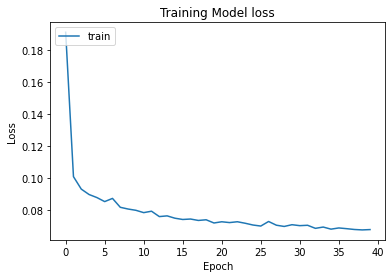

        Actual    Predicted
0    47.023903  [46.884415]
1    46.241833   [46.89307]
2    45.982750  [46.819824]
3    46.074760  [46.870205]
4    48.789028  [48.039677]
..         ...          ...
385  80.486107   [78.42131]
386  79.392090  [79.548744]
387  79.769165  [78.601906]
388  79.287888   [77.73693]
389  81.170799   [78.13604]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0713 - mean_squared_error: 0.0713
LSTM Model Loss =  [0.07131367921829224, 0.07131367921829224]
Model Accuracy =  [98.41441]
Mean Absolute Error =  0.800895201854217  degrees
Mean Squared Error =  0.9758590538221869
Root Mean Squared Error =  0.9878557859435693

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2338 - mean_squared_error: 0.2338
Epoch 2/40
71/71 [=========

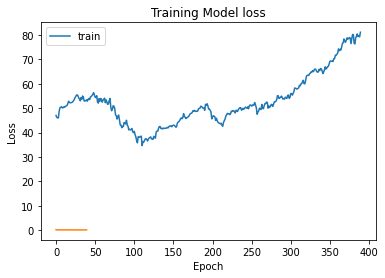

          Actual    Predicted
0    1808.000000  [1849.6979]
1    1817.270020  [1843.2733]
2    1779.219971  [1812.8931]
3    1777.439941  [1812.2428]
4    1797.170044  [1829.4517]
..           ...          ...
385  2050.229980  [2004.5455]
386  2079.280029  [2027.1616]
387  2133.909912  [2076.4722]
388  2150.800049   [2089.035]
389  2160.000000  [2100.6995]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0780 - mean_squared_error: 0.0780
LSTM Model Loss =  [0.07796525210142136, 0.07796525210142136]
Model Accuracy =  [98.22832]
Mean Absolute Error =  30.866660719651442  degrees
Mean Squared Error =  1725.6413687720894
Root Mean Squared Error =  41.54083976970241

--------------------------------------------------------------------------

Evaluating Model for Company:  ADM
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2189 - mean_squared_error: 0.2189
Epoc

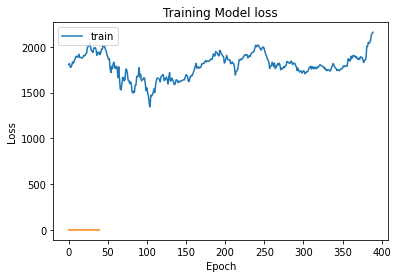

        Actual    Predicted
0    43.653885   [43.30755]
1    43.562386   [43.49909]
2    43.324490  [43.279705]
3    44.157127   [43.82932]
4    44.019875  [43.835297]
..         ...          ...
385  44.165833   [43.40679]
386  43.906483  [43.670353]
387  43.877670  [43.546097]
388  44.300312  [43.739525]
389  44.155090  [43.443375]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0738 - mean_squared_error: 0.0738
LSTM Model Loss =  [0.07379386574029922, 0.07379386574029922]
Model Accuracy =  [98.82841]
Mean Absolute Error =  0.4754430135091147  degrees
Mean Squared Error =  0.3411189346160826
Root Mean Squared Error =  0.5840538798913013

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2678 - mean_squared_error: 0.2678
Epoch 2/40
71/71 [========

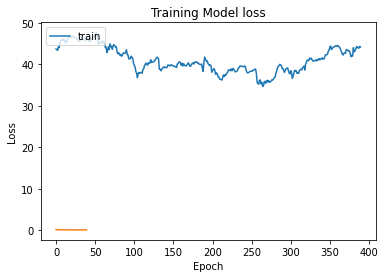

          Actual    Predicted
0    1268.329956  [1246.4819]
1    1238.500000  [1248.2262]
2    1219.739990  [1241.2006]
3    1217.260010  [1243.6589]
4    1220.010010  [1247.2821]
..           ...          ...
385  1476.229980   [1458.294]
386  1479.229980  [1473.8507]
387  1508.680054  [1481.5172]
388  1508.790039  [1478.5024]
389  1518.270020  [1486.9512]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0852 - mean_squared_error: 0.0852
LSTM Model Loss =  [0.08518438041210175, 0.08518438041210175]
Model Accuracy =  [98.54339]
Mean Absolute Error =  17.02790902944712  degrees
Mean Squared Error =  434.0213649393849
Root Mean Squared Error =  20.833179424643394

--------------------------------------------------------------------------

Evaluating Model for Company:  EBAY
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 3s 12ms/step - loss: 0.2154 - mean_squared_error: 0.2154
Epoc

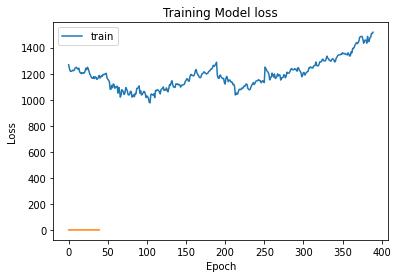

        Actual    Predicted
0    33.331360   [33.86515]
1    32.731140  [33.845936]
2    32.595608  [33.835426]
3    32.382629   [33.78057]
4    32.034122   [32.50038]
..         ...          ...
385  37.343075   [35.47887]
386  35.574196  [35.402702]
387  35.397308   [35.00745]
388  35.810051  [35.900764]
389  36.507778   [35.63631]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0700 - mean_squared_error: 0.0700
LSTM Model Loss =  [0.0699833482503891, 0.0699833482503891]
Model Accuracy =  [98.538956]
Mean Absolute Error =  0.48827488238994904  degrees
Mean Squared Error =  0.37992325951733324
Root Mean Squared Error =  0.6163791524032373

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2165 - mean_squared_error: 0.2165
Epoch 2/40
71/71 [========

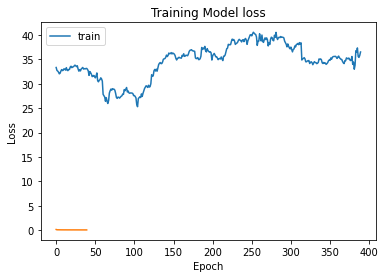

        Actual    Predicted
0    71.726852   [70.21981]
1    69.751480   [70.78717]
2    69.598213  [70.832756]
3    69.402374   [70.86859]
4    68.448746   [70.41267]
..         ...          ...
385  56.346684  [56.415802]
386  55.973351  [55.979076]
387  55.382210  [55.986088]
388  55.908691  [56.034676]
389  56.592194  [55.977673]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0775 - mean_squared_error: 0.0775
LSTM Model Loss =  [0.07754634320735931, 0.07754634320735931]
Model Accuracy =  [98.73176]
Mean Absolute Error =  0.831764612442408  degrees
Mean Squared Error =  1.0845881761818863
Root Mean Squared Error =  1.0414356322797325

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (390, 1)
Epoch 1/40
71/71 [==============================] - 4s 12ms/step - loss: 0.2661 - mean_squared_error: 0.2661
Epoch 2/40
71/71 [==========

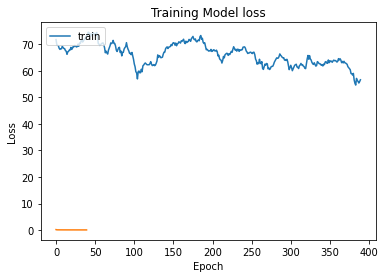

        Actual    Predicted
0    63.071827  [61.888664]
1    62.687599  [62.250607]
2    62.601139  [62.464046]
3    62.956558  [61.853134]
4    62.226517  [62.391922]
..         ...          ...
385  88.100525   [86.68346]
386  86.525017  [86.449715]
387  86.948433  [86.444435]
388  87.805115   [86.52129]
389  87.430931  [86.520004]

[390 rows x 2 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0974 - mean_squared_error: 0.0974
LSTM Model Loss =  [0.09743871539831161, 0.09743871539831161]
Model Accuracy =  [98.70441]
Mean Absolute Error =  0.9661793439816206  degrees
Mean Squared Error =  1.4262896045753637
Root Mean Squared Error =  1.1942736723948006

--------------------------------------------------------------------------



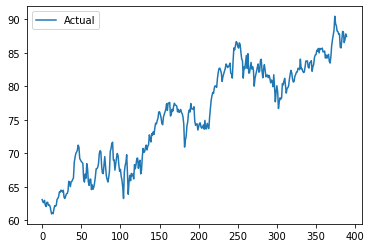

In [55]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = with_news(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)

In [56]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.800895,0.975859,[98.41441],0.987856
1,AMZN,30.866661,1725.641369,[98.22832],41.540840
2,ADM,0.475443,0.341119,[98.82841],0.584054
3,GOOG,17.027909,434.021365,[98.54339],20.833179
4,EBAY,0.488275,0.379923,[98.538956],0.616379
5,XOM,0.831765,1.084588,[98.73176],1.041436
6,ABT,0.966179,1.426290,[98.70441],1.194274


In [59]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE            7.35102
MSE            309.124
Accuracy    [98.56995]
RMSE           9.54257
dtype: object

In [60]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P13_RNN_All_Companies_without_news"+current_time+".csv"
company_results.to_csv(name)